<a href="https://colab.research.google.com/github/Binhcore/I2D/blob/main/%5BFULL_CODE%5D_Lecture_8_Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.10.0+cu111


### MNIST dataset is provided in default

In [ ]:
train_path = './sample_data/mnist_train_small.csv'
test_path = './sample_data/mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28**2 for image


In [ ]:
def mnist_reader(file_path, img_size=img_size):
    total_img = list()
    total_label = list()
    with open(file_path) as csvfile:
        mnist_reader = csv.reader(csvfile)
        for row in tqdm(mnist_reader):
            img = np.array(row[1:], dtype=np.uint16).reshape(img_size, img_size)
            img = img / 255
            label = int(row[0])

            total_img.append(img)
            total_label.append(label)

    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)
    
    return total_img, total_label

In [ ]:
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Define the Dataset

In [ ]:
class MNIST_Dataset(Dataset):
    def __init__(self, target_img, target_label):
        self.target_img = target_img
        self.target_label = target_label
        self.num_data = target_img.shape[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['img'] = self.target_img[idx]
        sample['label'] = self.target_label[idx]

        return sample

### Define the DataLoader

In [ ]:
batch_size = 64

train_dataset = MNIST_Dataset(train_img, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(train_dataloader))
print(sample['img'].shape)
print(sample['label'].shape)

torch.Size([64, 28, 28])
torch.Size([64])


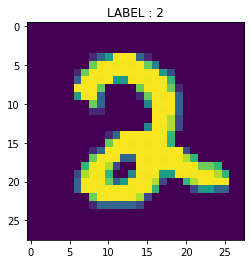

In [ ]:
plot_idx = 0
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### Define the VAE (encoder + decoder)
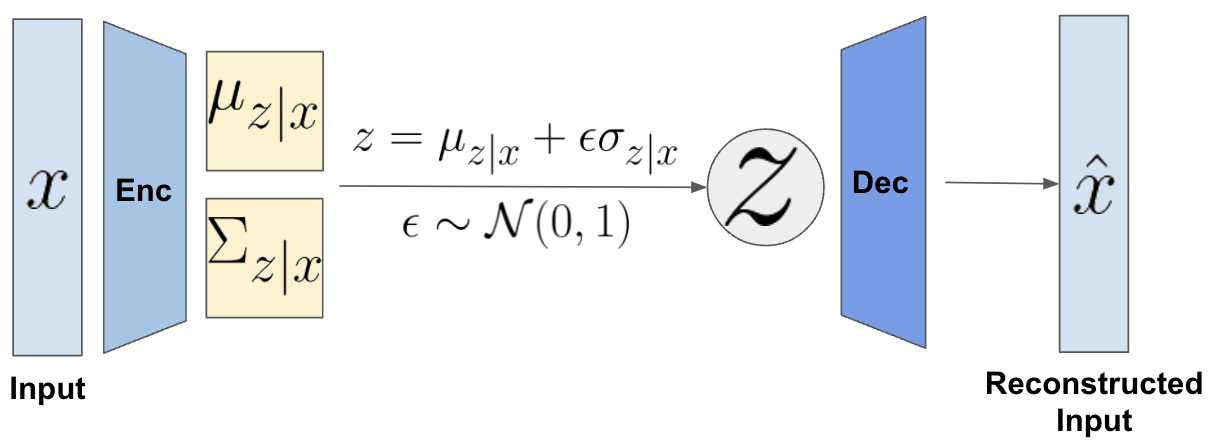

In [ ]:
class VAE(nn.Module):
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_z, dim_input=img_size**2):
        super(VAE, self).__init__()
        
        # define hidden dimension for encoder and decoder
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_z = dim_z
        self.dim_input = dim_input

        # define encoder
        self.enc_1 = nn.Linear(dim_input, dim_hidden_1)
        self.enc_2 = nn.Linear(dim_hidden_1, dim_hidden_2)
        self.enc_z_mean = nn.Linear(dim_hidden_2, dim_z)
        self.enc_z_logvar = nn.Linear(dim_hidden_2, dim_z)

        # define decoder
        self.dec_1 = nn.Linear(dim_z, dim_hidden_2)
        self.dec_2 = nn.Linear(dim_hidden_2, dim_hidden_1)
        self.dec_3 = nn.Linear(dim_hidden_1, dim_input)
    
        self.activation = nn.ReLU()

    def encoder(self, img):
        batch_size = img.shape[0]
        input = img.view(batch_size, -1)

        tmp_z = self.activation(self.enc_1(input))
        tmp_z = self.activation(self.enc_2(tmp_z))
        z_mean = self.enc_z_mean(tmp_z)
        z_logvar = self.enc_z_logvar(tmp_z)

        return z_mean, z_logvar

    def sampling(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z_sample = torch.mul(eps, std) + mean
        return z_sample 
        
    def decoder(self, z_sample):
        out = self.activation(self.dec_1(z_sample))
        out = self.activation(self.dec_2(out))
        out = torch.sigmoid(self.dec_3(out))
        return out
    
    def forward(self, img):
        z_mean, z_logvar = self.encoder(img)
        z_sample = self.sampling(z_mean, z_logvar)
        return self.decoder(z_sample), z_mean, z_logvar

### Define the Model

In [ ]:
dim_hidden_1 = 512
dim_hidden_2 = 256
dim_z = 128
model = VAE(dim_hidden_1, dim_hidden_2, dim_z)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model)

VAE(
  (enc_1): Linear(in_features=784, out_features=512, bias=True)
  (enc_2): Linear(in_features=512, out_features=256, bias=True)
  (enc_z_mean): Linear(in_features=256, out_features=128, bias=True)
  (enc_z_logvar): Linear(in_features=256, out_features=128, bias=True)
  (dec_1): Linear(in_features=128, out_features=256, bias=True)
  (dec_2): Linear(in_features=256, out_features=512, bias=True)
  (dec_3): Linear(in_features=512, out_features=784, bias=True)
  (activation): ReLU()
)


#### Note that the KL dirvergence $D_{KL}(q_\phi(z|x^{(i)}\|p_\theta(z))$ is calculated as
#### -$\frac{1}{2}\sum_{j=1}^{J}\Big( 1 + \log((\sigma_j^{(i)})^2) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2 \Big)$

In [ ]:
def criterion(recon_img, img, z_mean, z_logvar):
    BCE_loss = F.binary_cross_entropy(recon_img, img.view(-1, img_size**2), reduction='sum')
    KL_loss = -0.5 * torch.sum(1 + z_logvar - z_mean**2 - torch.exp(z_logvar))
    return BCE_loss + KL_loss

### Define functions for train/test

In [ ]:
def train(model, optimizer, sample):
    model.train()
    optimizer.zero_grad()

    img = sample['img'].float().to(device)
    
    recon_img, z_mean, z_logvar = model(img)

    curr_loss = criterion(recon_img, img, z_mean, z_logvar)

    curr_loss.backward()
    optimizer.step()

    return curr_loss.item()

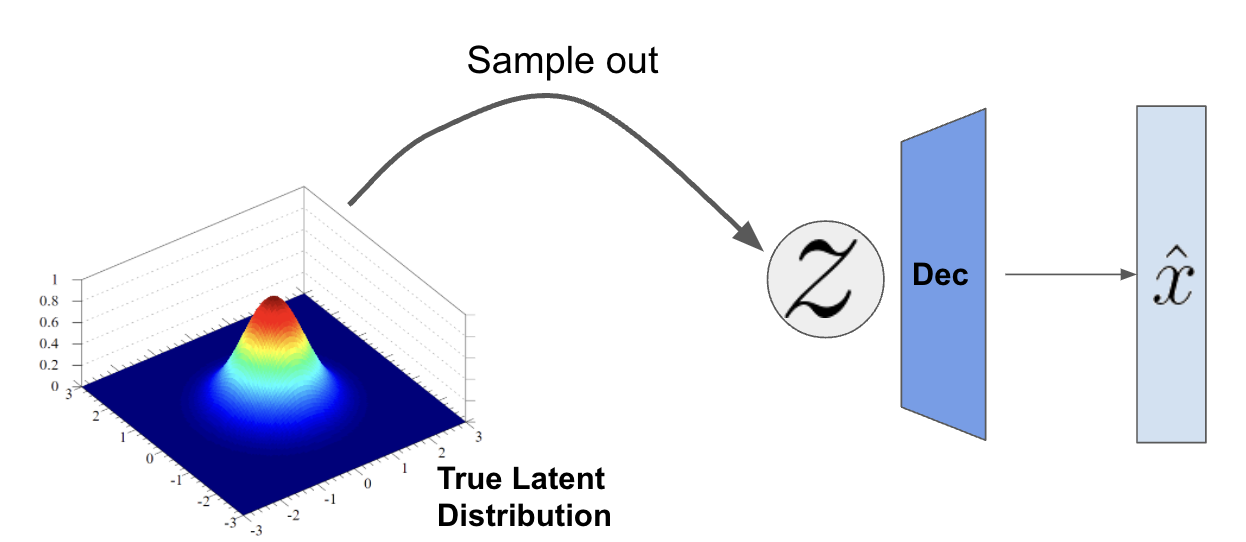

In [ ]:
def test(model):
    model.eval()
    with torch.no_grad():
        z_sample = torch.randn(1, dim_z).to(device)
        gen_out = model.decoder(z_sample)

    return gen_out.view(img_size, img_size).detach().cpu().numpy()

### Run Training

In [ ]:
max_epoch = 100

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss
    train_loss = 0.0

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataloader)
        
    print('[EPOCH {}] SAMPLED TRAINING LOSS : {}'.format(epoch, train_loss))

  0%|          | 0/100 [00:00<?, ?it/s]

[EPOCH 0] SAMPLED TRAINING LOSS : 16296.436532797523
[EPOCH 1] SAMPLED TRAINING LOSS : 12730.107248714567
[EPOCH 2] SAMPLED TRAINING LOSS : 12396.570501260489
[EPOCH 3] SAMPLED TRAINING LOSS : 12117.31592888878
[EPOCH 4] SAMPLED TRAINING LOSS : 11737.565694888179
[EPOCH 5] SAMPLED TRAINING LOSS : 11238.828720921529
[EPOCH 6] SAMPLED TRAINING LOSS : 10584.79679543979
[EPOCH 7] SAMPLED TRAINING LOSS : 10316.205536766174
[EPOCH 8] SAMPLED TRAINING LOSS : 10129.139476837057
[EPOCH 9] SAMPLED TRAINING LOSS : 9956.94428133736
[EPOCH 10] SAMPLED TRAINING LOSS : 9784.612657248406
[EPOCH 11] SAMPLED TRAINING LOSS : 9637.27872435353
[EPOCH 12] SAMPLED TRAINING LOSS : 9517.216484874207
[EPOCH 13] SAMPLED TRAINING LOSS : 9380.70950385632
[EPOCH 14] SAMPLED TRAINING LOSS : 9266.569690058403
[EPOCH 15] SAMPLED TRAINING LOSS : 9140.610995844152
[EPOCH 16] SAMPLED TRAINING LOSS : 9023.394999251199
[EPOCH 17] SAMPLED TRAINING LOSS : 8907.313924283646
[EPOCH 18] SAMPLED TRAINING LOSS : 8799.308749750393

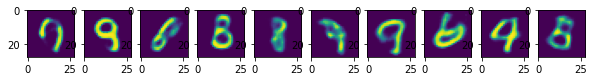

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    ax[i].imshow(test(model))